# Working with the U.S. Education Dataset from Kaggle. The data gives detailed state level information on the several facets of the state of education on annual basis.

## https://www.kaggle.com/noriuk/us-education-datasets-unification-project/

In [126]:
import pandas as pd
import math
import numpy as np
from numpy import percentile
from numpy.random import seed
from sqlalchemy import create_engine
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

##  We want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

In [70]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df0 = pd.read_sql_query('select * from useducation', con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Explore the data

In [71]:
nRow, nCol = df0.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1492 rows and 25 columns


In [72]:
# Help functions to gather basic descriptions
def describe(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mean abs dev'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                      df.nunique().rename('unique')
                     ], axis=1).T

In [73]:
# Non-numerical describe
df_stat = df0.describe(include = ['O']) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,PRIMARY_KEY,STATE
count,1492,1492
unique,1487,80
top,2008_VIRGINIA,DISTRICT_OF_COLUMBIA
freq,3,29
dtype,object,object
size,1492,1492
% null,0,0


In [74]:
# Numerical describe
df_stat = df0.describe(include = [np.number]) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,1492,1229,1280,1280,1280,1280,1280,1280,1280,1229,...,1361,1361,1361,1361,1361,1319,536,532,533,498
mean,2004.43,915931,9.09208e+06,766372,4.21655e+06,4.10916e+06,9.19668e+06,4.76297e+06,2.68033e+06,429205,...,64538.9,64271.1,54268.9,519214,247071,802442,234.768,278.415,218.866,263.661
std,7.39398,1.06528e+06,1.17452e+07,1.14524e+06,5.54307e+06,5.48297e+06,1.19781e+07,6.293e+06,3.35335e+06,534069,...,80293.4,78910.5,67889.3,643638,307706,970703,10.2215,10.1597,7.76962,6.80373
min,1992,43866,465650,31020,0,22093,481665,265549,139963,11541,...,633,437,311,4878,1808,7254,187.135,232.832,178.558,236.379
25%,1998,258314,2.18631e+06,189354,1.1531e+06,715834,2.1654e+06,1.16803e+06,635790,102831,...,13739,13342,10919,110626,51471,181065,229.694,272.762,214.663,259.533
50%,2004,648313,5.07955e+06,403376,2.53707e+06,2.05578e+06,5.23451e+06,2.65745e+06,1.52541e+06,271596,...,43272,43339,36735,345775,164260,550342,237.239,280.619,220.416,265.011
75%,2011,1.01453e+06,1.08598e+07,828966,5.08094e+06,4.76868e+06,1.07452e+07,5.56803e+06,3.22965e+06,518600,...,75481,76566,67460,611905,290502,928276,241.995,285.347,223.999,268.19
max,2017,6.30702e+06,8.92173e+07,9.99022e+06,5.09046e+07,3.61053e+07,8.53201e+07,4.39645e+07,2.6058e+07,3.99595e+06,...,493415,500143,498403,3.92987e+06,2.01369e+06,5.94475e+06,253.421,300.568,236.774,280.499
dtype,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
size,1492,1492,1492,1492,1492,1492,1492,1492,1492,1492,...,1492,1492,1492,1492,1492,1492,1492,1492,1492,1492


In [75]:
# Fill missing values with mean
df0 = df0.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'float64' else x.fillna('NaN'))

## Explore and fix any outliers

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23]),
 <a list of 23 Text major ticklabel objects>)

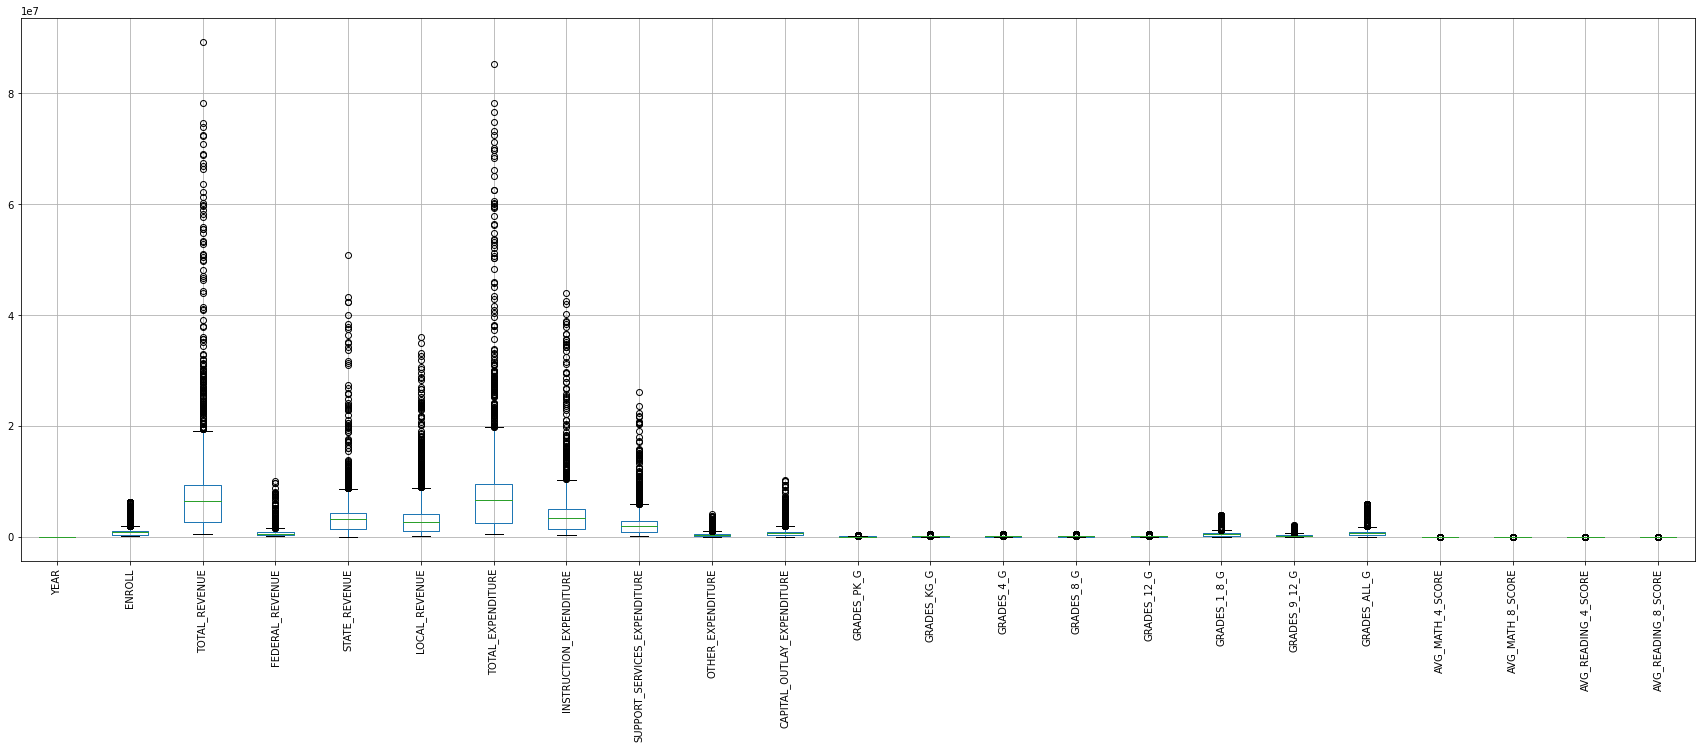

In [76]:
plt.figure(figsize = (30,10))
df0.boxplot()
plt.xticks(rotation=90)


In [77]:
df0.columns

Index(['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'],
      dtype='object')

In [78]:
# plt.figure(figsize = (20,5))
# plt.subplot(1,3,1)
# plt.boxplot(x=df0["math score"])
# plt.ylabel("Count", size=20)
# plt.title("Math Score Distribution", size=20)
# plt.tick_params(axis = 'both', which = 'minor', labelsize = 16)

# plt.subplot(1,3,2)
# plt.boxplot(x=df0["math score"])
# plt.ylabel("Count", size=20)
# plt.title("Reading Score Distribution", size=20)
# plt.tick_params(axis = 'both', which = 'minor', labelsize = 16)

# plt.subplot(1,3,3)
# plt.boxplot(x=df0["math score"])
# plt.ylabel("Count", size=20)
# plt.title("Writing Score Distribution", size=20)
# plt.tick_params(axis = 'both', which = 'minor', labelsize = 16)

# plt.show

## Basic Summaries

#### Quartile: An observed value at a point that aids in splitting the ordered data sample into four equally sized parts. 

#### Median or 2nd quartile: The middle value in the sample, also called the 50th percentile or the 2nd quartile splits the ordered data sample into two
#### 1st and 3rd quartiles split each of median/2nd quartile halves into quarters. 
#### A percentile is an observed value at a point that aids in splitting the ordered data sample into 100 equally sized portions. Quartiles are often also expressed as percentiles.
#### 1st Quartile: The 25th percentile.
#### 3rd Quartile: The 75th percentile.
#### Minimum: The smallest observation in the sample.
#### Maximum: The largest observation in the sample.

In [79]:
# q25, q50, q75 = np.percentile(df0["math score"], [25, 50, 75])
# # calculate min/max
# data_min, data_max = df0["math score"].min(), df0["math score"].max()


# print('Min: %.3f' % data_min)
# print('Q1: %.3f' % q25)
# print('Median: %.3f' % q50)
# print('Q3: %.3f' % q75)
# print('Max: %.3f' % data_max)

## Z-score

### One statistic used to detect the outliers in a variable is the Z-score. To calculate Z-scores, we will first scale the variable so that its mean is 0 and its standard deviation is 1. Then we can measure how far a value is far away from the mean (0) in terms of standard deviations (1). The bigger the Z-score of a value, the farther it is from the mean, and the more likely it is an outlier. However, we still need to set a threshold for what Z-score constitutes an outlier.

#### Measure z scores for all reaidng and math variabls

In [80]:
# Avg Math 4 Score
z_scores = zscore(df0["AVG_MATH_4_SCORE"])
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([ 588,  594,  596,  602,  606,  618,  623,  682,  688,  692,  697,
        699,  705,  706,  709,  710,  711,  717,  719,  721,  723,  726,
        786,  787,  789,  792,  794,  795,  796,  799,  801,  803,  806,
        810,  811,  813,  814,  815,  816,  819,  822,  824,  826,  827,
        828,  830,  831,  892,  893,  897,  900,  902,  903,  904,  907,
        908,  909,  911,  914,  916,  918,  919,  922,  923,  924,  927,
        930,  934,  935,  936,  938,  939,  998,  999, 1007, 1008, 1009,
       1012, 1013, 1014, 1016, 1019, 1022, 1023, 1026, 1027, 1028, 1031,
       1032, 1034, 1036, 1037, 1038, 1039, 1040, 1042, 1043, 1102, 1103,
       1104, 1106, 1108, 1111, 1112, 1113, 1114, 1116, 1117, 1118, 1120,
       1123, 1124, 1126, 1127, 1130, 1131, 1132, 1135, 1136, 1138, 1140,
       1141, 1142, 1143, 1144, 1146, 1147, 1204, 1208, 1213, 1214, 1215,
       1216, 1218, 1220, 1222, 1225, 1226, 1228, 1229, 1232, 1233, 1

In [81]:
# Avg Math 8 Score
z_scores = zscore(df0["AVG_MATH_8_SCORE"])
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([ 439,  442,  594,  596,  599,  602,  607,  614,  618,  697,  699,
        702,  705,  710,  717,  721,  723,  725,  785,  794,  795,  796,
        799,  800,  801,  803,  806,  810,  811,  815,  816,  819,  822,
        824,  826,  827,  828,  830,  831,  892,  893,  900,  902,  904,
        907,  908,  909,  911,  913,  914,  916,  918,  919,  923,  924,
        926,  927,  930,  932,  934,  935,  936,  938,  939,  998,  999,
       1005, 1007, 1008, 1009, 1012, 1013, 1014, 1016, 1019, 1022, 1023,
       1026, 1027, 1028, 1031, 1034, 1036, 1038, 1039, 1040, 1042, 1043,
       1102, 1103, 1109, 1110, 1111, 1112, 1113, 1116, 1117, 1118, 1120,
       1123, 1124, 1126, 1127, 1130, 1131, 1132, 1135, 1138, 1140, 1142,
       1143, 1144, 1146, 1147, 1204, 1213, 1214, 1218, 1220, 1222, 1225,
       1226, 1228, 1229, 1233, 1234, 1240, 1243, 1244, 1245, 1246, 1248,
       1249, 1349, 1452, 1461, 1462, 1463, 1468, 1470, 1473, 1474, 1

In [82]:
# Avg Reading 4 Score
z_scores = zscore(df0["AVG_READING_4_SCORE"])
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([  19,   34,   50,  215,  228,  230,  235,  238,  258,  422,  423,
        435,  437,  439,  442,  451,  462,  463,  464,  577,  578,  579,
        591,  594,  602,  603,  618,  681,  682,  683,  695,  697,  699,
        702,  705,  710,  721,  722,  785,  786,  787,  789,  795,  796,
        799,  800,  801,  803,  806,  810,  811,  813,  815,  816,  819,
        826,  827,  828,  831,  892,  893,  894,  897,  904,  905,  907,
        908,  909,  913,  914,  918,  919,  921,  923,  924,  927,  934,
        935,  999, 1000, 1002, 1009, 1010, 1013, 1014, 1019, 1022, 1023,
       1027, 1028, 1031, 1038, 1039, 1043, 1102, 1103, 1104, 1106, 1111,
       1112, 1114, 1116, 1117, 1118, 1120, 1126, 1127, 1129, 1131, 1132,
       1135, 1142, 1143, 1144, 1147, 1204, 1205, 1206, 1208, 1213, 1214,
       1216, 1218, 1220, 1225, 1226, 1228, 1229, 1232, 1233, 1234, 1237,
       1238, 1243, 1244, 1245, 1246, 1249, 1349, 1452, 1453, 1456, 1

In [83]:
# Avg Reading 8 Score
z_scores = zscore(df0["AVG_READING_8_SCORE"])
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([ 212,  213,  214,  224,  227,  235,  238,  240,  245,  372,  418,
        419,  433,  441,  444,  447,  451,  452,  453,  460,  461,  463,
        573,  574,  578,  584,  588,  600,  602,  604,  607,  610,  611,
        615,  622,  676,  691,  702,  704,  706,  709,  712,  713,  717,
        724,  784,  794,  805,  807,  810,  813,  816,  817,  821,  822,
        825,  828,  890,  898,  901,  912,  914,  917,  920,  923,  924,
        928,  929,  932,  935,  939,  995, 1001, 1002, 1005, 1009, 1014,
       1016, 1017, 1018, 1020, 1023, 1024, 1026, 1027, 1031, 1032, 1035,
       1038, 1042, 1059, 1096, 1098, 1104, 1105, 1108, 1112, 1115, 1117,
       1119, 1120, 1121, 1123, 1126, 1127, 1129, 1130, 1134, 1135, 1137,
       1138, 1141, 1144, 1145, 1146, 1147, 1199, 1205, 1206, 1209, 1213,
       1215, 1216, 1218, 1220, 1221, 1222, 1224, 1227, 1228, 1230, 1231,
       1238, 1239, 1245, 1246, 1452, 1453, 1456, 1460, 1462, 1463, 1

### There are few outliers with more than 4 stadard deviaiton that we should fix

### If outliers are a problem for our analysis we can use winsorization to limit their values. The idea in winsorization is to set the values of the extreme points to the value of a specified percentile. For example, we may set the values of the highest end of the distribution to the value of the 95th percentile. Similarly, we can set the values of the lowest end to the value of the 5th percentile.

In [84]:
for col in df0.columns:
    df0[col] = stats.mstats.winsorize(df0[col], limits=0.05)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23]),
 <a list of 23 Text major ticklabel objects>)

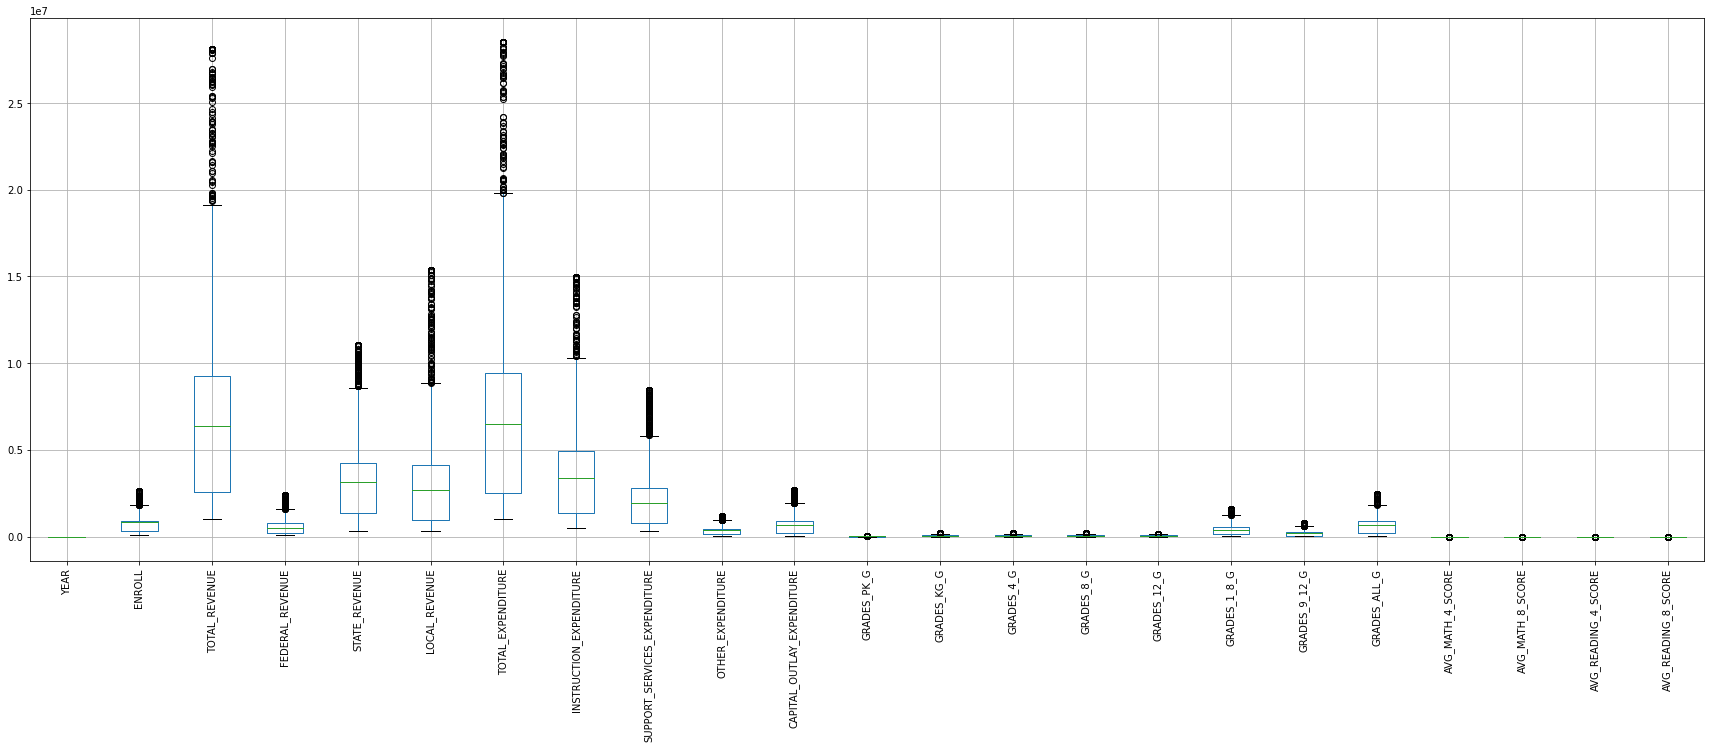

In [85]:
# Plot after winsorization
plt.figure(figsize = (30,10))
df0.boxplot()
plt.xticks(rotation=90)


# 1. Compute the average score for each row for all students weighted properly by grade. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores.

In [86]:
df0.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1993_KANSAS,ARIZONA,1993,915930.820993,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,223.350133,267.755031,210.410726,263.661132
1,1993_KANSAS,ARIZONA,1993,915930.820993,1049591.0,106780.0,720711.0,321422.0,993823.0,501563.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,234.768293,278.414711,218.866154,258.859712
2,1993_KANSAS,ARIZONA,1993,915930.820993,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,223.350133,267.755031,210.410726,262.169895
3,1993_KANSAS,ARKANSAS,1993,915930.820993,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,223.350133,267.755031,210.410726,264.619665
4,1993_KANSAS,CALIFORNIA,1993,915930.820993,26260025.0,2072470.0,11047025.0,7641041.0,27138832.0,14358922.0,...,196988.0,200378.0,153112.0,1607001.0,781725.0,2447442.0,223.350133,267.755031,210.410726,263.661132


In [87]:
df0['grade_4_weight'] = (df0['GRADES_4_G']/(df0['GRADES_4_G']+df0['GRADES_8_G']))
df0['grade_8_weight'] = (df0['GRADES_8_G']/(df0['GRADES_4_G']+df0['GRADES_8_G']))
df0['avg_4_grade_score'] = (df0['AVG_MATH_4_SCORE']+df0['AVG_READING_4_SCORE'])/2
df0['avg_8_grade_score'] = (df0['AVG_MATH_8_SCORE']+df0['AVG_READING_8_SCORE'])/2                            
df0['avg_math_4_8_math_score'] = (df0['grade_4_weight']*df0['avg_4_grade_score'])+(df0['grade_8_weight']*df0['avg_8_grade_score'])


<function matplotlib.pyplot.show(*args, **kw)>

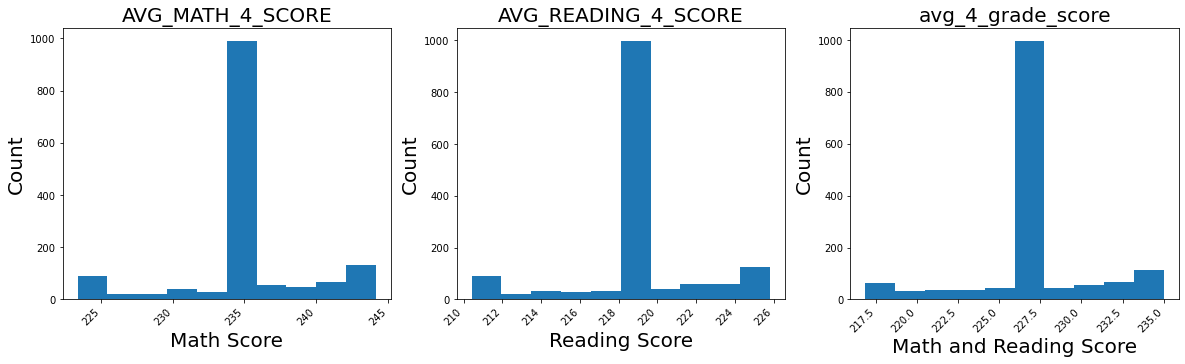

In [88]:
plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
plt.hist(df0["AVG_MATH_4_SCORE"])
plt.xlabel("Math Score", size=20)
plt.ylabel("Count", size=20)
plt.title("AVG_MATH_4_SCORE", size=20)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 16)
plt.xticks(rotation=45, ha='right')

plt.subplot(1,3,2)
plt.hist(df0["AVG_READING_4_SCORE"])
plt.xlabel("Reading Score", size=20)
plt.ylabel("Count", size=20)
plt.title("AVG_READING_4_SCORE", size=20)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 16)
plt.xticks(rotation=45, ha='right')

plt.subplot(1,3,3)
plt.hist(df0["avg_4_grade_score"])
plt.xlabel("Math and Reading Score", size=20)
plt.ylabel("Count", size=20)
plt.title("avg_4_grade_score", size=20)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 16)
plt.xticks(rotation=45, ha='right')

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

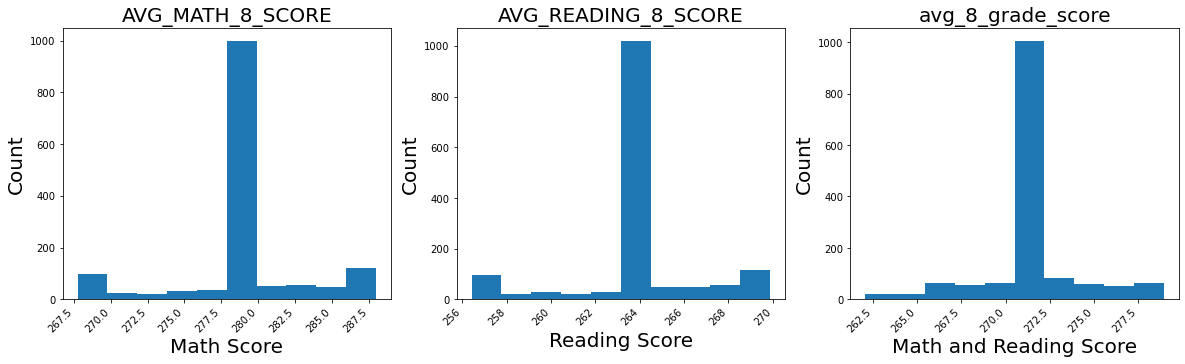

In [89]:
plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
plt.hist(df0["AVG_MATH_8_SCORE"])
plt.xlabel("Math Score", size=20)
plt.ylabel("Count", size=20)
plt.title("AVG_MATH_8_SCORE", size=20)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 16)
plt.xticks(rotation=45, ha='right')

plt.subplot(1,3,2)
plt.hist(df0["AVG_READING_8_SCORE"])
plt.xlabel("Reading Score", size=20)
plt.ylabel("Count", size=20)
plt.title("AVG_READING_8_SCORE", size=20)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 16)
plt.xticks(rotation=45, ha='right')

plt.subplot(1,3,3)
plt.hist(df0["avg_8_grade_score"])
plt.xlabel("Math and Reading Score", size=20)
plt.ylabel("Count", size=20)
plt.title("avg_8_grade_score", size=20)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 16)
plt.xticks(rotation=45, ha='right')

plt.show

# 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

## Average scores has highest correlation with the support srevice expensitures

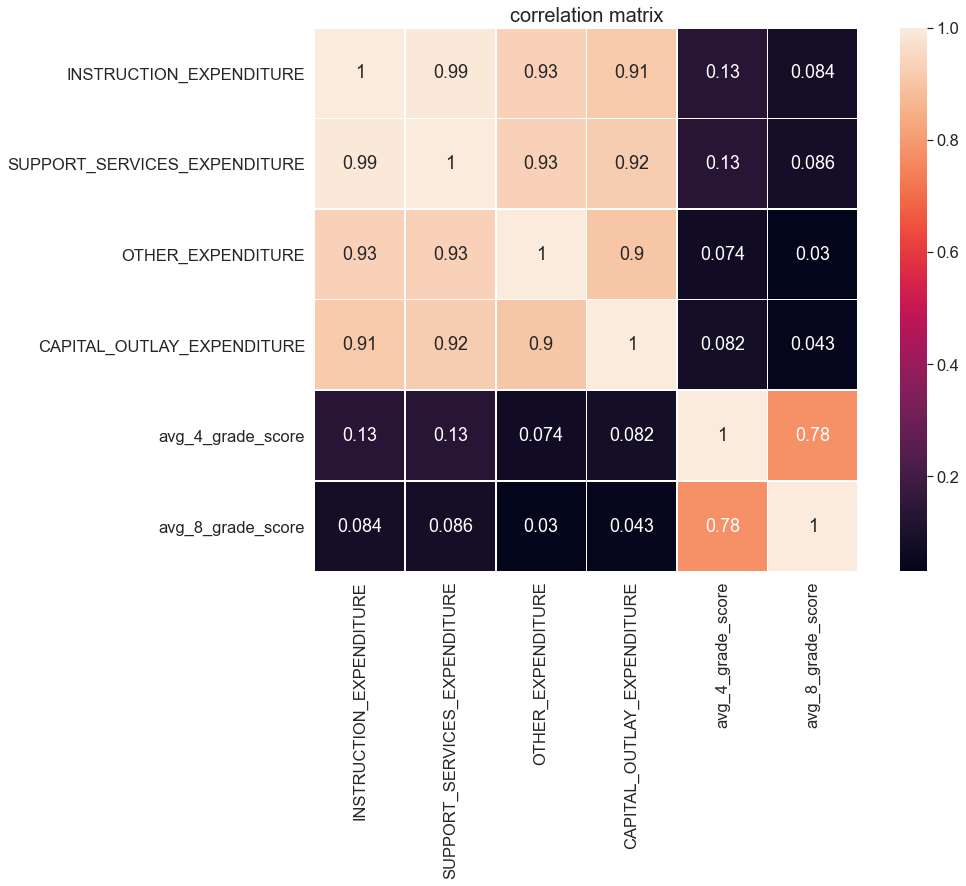

In [114]:
# make the correlation matrices.
df1 = df0[['INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE'\
           , 'OTHER_EXPENDITURE','CAPITAL_OUTLAY_EXPENDITURE' \
           ,'avg_4_grade_score', 'avg_8_grade_score']]
corrmat_scores = df1.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(15,10))
# draw the heatmap using seaborn.
sns.heatmap(corrmat_scores, square=True, annot=True, linewidths=.5) #, label='small')
plt.title("correlation matrix", size=20)
plt.show()

# 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

In [115]:
df1.columns

Index(['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
       'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'avg_4_grade_score',
       'avg_8_grade_score'],
      dtype='object')

In [113]:
df1.head(2)

""


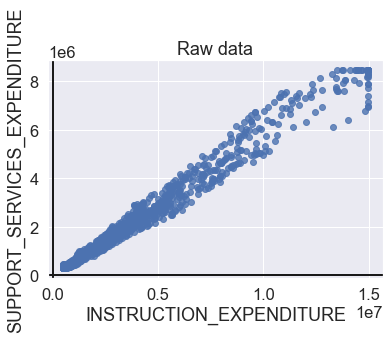

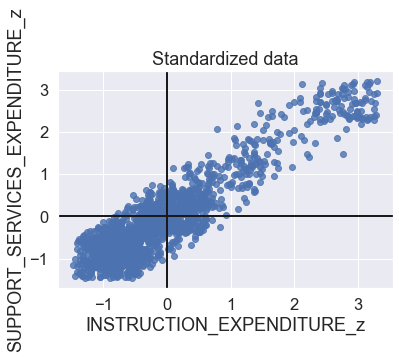

In [119]:
t = sns.regplot(
    'INSTRUCTION_EXPENDITURE',
    'SUPPORT_SERVICES_EXPENDITURE',
    df1,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
#t.set(xlim=(-1, 11), ylim=(-1, 11))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Raw data')
plt.show()


# Standardizing variables by subtracting the mean and dividing by the standard
# deviation. Now both variables are on the same scale.
df1_z = pd.DataFrame()
df1_z['INSTRUCTION_EXPENDITURE_z'] = (df1['INSTRUCTION_EXPENDITURE'] - df1['INSTRUCTION_EXPENDITURE'].mean()) / df1['INSTRUCTION_EXPENDITURE'].std()
df1_z['SUPPORT_SERVICES_EXPENDITURE_z'] = (df1['SUPPORT_SERVICES_EXPENDITURE'] - df1['SUPPORT_SERVICES_EXPENDITURE'].mean()) / df1['SUPPORT_SERVICES_EXPENDITURE'].std()

t = sns.regplot(
    'INSTRUCTION_EXPENDITURE_z',
    'SUPPORT_SERVICES_EXPENDITURE_z',
    df1_z,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()

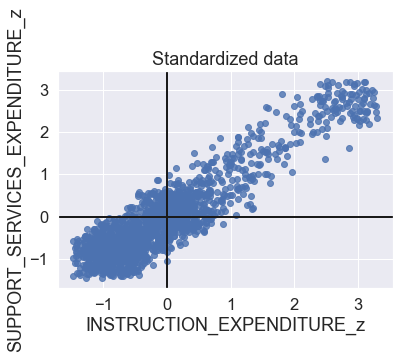

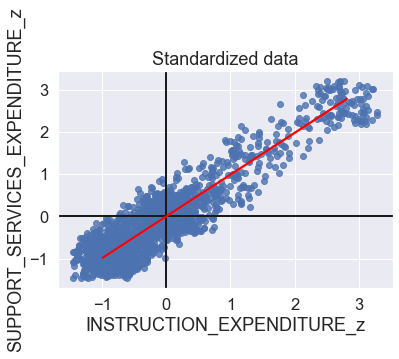

In [128]:
t = sns.regplot(
    'INSTRUCTION_EXPENDITURE_z',
    'SUPPORT_SERVICES_EXPENDITURE_z',
    df1_z,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')

sns.regplot('INSTRUCTION_EXPENDITURE_z',
            'SUPPORT_SERVICES_EXPENDITURE_z',
            df1_z, 
            scatter=False, 
            color="red")
plt.show()

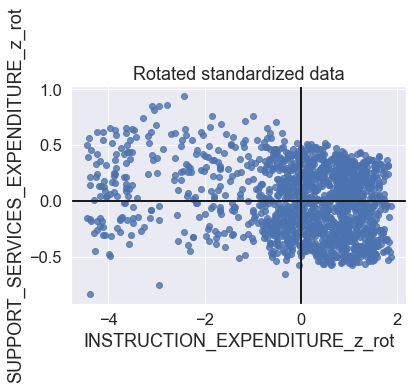

In [133]:
# Rotating the data so that the axes roughly match to vector above.
df1['INSTRUCTION_EXPENDITURE_z_rot'] = math.cos(40) * df1_z['INSTRUCTION_EXPENDITURE_z'] - math.sin(40) * df1_z['INSTRUCTION_EXPENDITURE_z']
df1['SUPPORT_SERVICES_EXPENDITURE_z_rot'] = math.sin(40) * df1_z['SUPPORT_SERVICES_EXPENDITURE_z'] + math.cos(40) * df1_z['INSTRUCTION_EXPENDITURE_z']

t = sns.regplot(
    'INSTRUCTION_EXPENDITURE_z_rot',
    'SUPPORT_SERVICES_EXPENDITURE_z_rot',
    df1,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()


## After roation we can see there is more information in horzontal variable than the vertical one. This will help us to decide if dropping a variable is worthwhile.

## Now let's use Python built-in module to calculate principal components

In [134]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.

X = StandardScaler().fit_transform(df1)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00067069  0.99240818  0.93426486  0.9151188   0.13491529  0.08367476
  -1.00067069  0.60231222]
 [ 0.99240818  1.00067069  0.93347178  0.92143428  0.1349308   0.08572134
  -0.99240818  0.69981645]
 [ 0.93426486  0.93347178  1.00067069  0.9025987   0.07378308  0.03041126
  -0.93426486  0.60544022]
 [ 0.9151188   0.92143428  0.9025987   1.00067069  0.08210632  0.04315787
  -0.9151188   0.63719705]
 [ 0.13491529  0.1349308   0.07378308  0.08210632  1.00067069  0.78065351
  -0.13491529  0.08824016]
 [ 0.08367476  0.08572134  0.03041126  0.04315787  0.78065351  1.00067069
  -0.08367476  0.06741096]
 [-1.00067069 -0.99240818 -0.93426486 -0.9151188  -0.13491529 -0.08367476
   1.00067069 -0.60231222]
 [ 0.60231222  0.69981645  0.60544022  0.63719705  0.08824016  0.06741096
  -0.60231222  1.00067069]]


In [136]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)    

Eigenvector 1: 
[ 0.4270242   0.43261855  0.4145212   0.41252021  0.07143786  0.050532
 -0.4270242   0.31382203]
Eigenvalue 1: 5.272811555607438
----------------------------------------
Eigenvector 2: 
[ 0.02233559  0.02242045  0.06781777  0.0584954  -0.70074488 -0.70654552
 -0.02233559  0.01512087]
Eigenvalue 2: 1.75896990835834
----------------------------------------
Eigenvector 3: 
[-0.20730088 -0.03501484 -0.16385236 -0.07905369 -0.02919038  0.01252223
  0.20730088  0.93740103]
Eigenvalue 3: 0.5467231649128896
----------------------------------------
Eigenvector 4: 
[ 0.00854843  0.01176605 -0.0310614  -0.05403492  0.70529736 -0.70549983
 -0.00854843  0.02562122]
Eigenvalue 4: 0.2189801480796751
----------------------------------------
Eigenvector 5: 
[ 0.3120297   0.2875201  -0.14227653 -0.83352467 -0.06881147  0.01553024
 -0.3120297   0.05123408]
Eigenvalue 5: 0.11855240056917833
----------------------------------------
Eigenvector 6: 
[-0.19058072 -0.16501105  0.88063495 -0.349

In [137]:
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

## How many components we shoule pick?

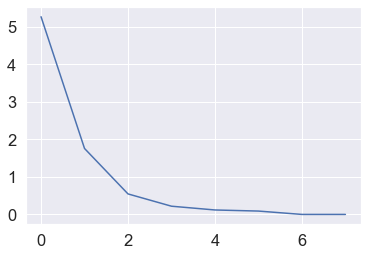

[ 5.27281156e+00  1.75896991e+00  5.46723165e-01  2.18980148e-01
  1.18552401e-01  8.93283490e-02  7.64300552e-16 -5.52884558e-16]


In [138]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

## Both the scree plot and the eigenvalues >1 rule agree that we should keep only the 1st 2 components. And the first component explains 65% of data variance.|

### Now it's time to create P, transform X into Y, and look at how well our new component correlates with our old variables.

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.65865969 0.21972387 0.06829459 0.02735417 0.01480912 0.01115856]


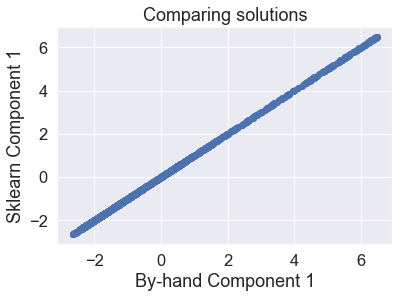

In [141]:
sklearn_pca = PCA(n_components=6)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

# 4. What is the correlation between the overall score variable and the 1st principal component?

In [144]:
PCA_df1 = pd.DataFrame(data = Y_sklearn, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'])

In [151]:
print('Explained variation per principal component: {}'.format(sklearn_pca.explained_variance_ratio_))

Explained variation per principal component: [0.65865969 0.21972387 0.06829459 0.02735417 0.01480912 0.01115856]


In [153]:
PCA_df1.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,avg_8_grade_score,avg_4_grade_score
0,-1.819020,3.364522,0.312298,-0.556179,0.144747,-0.704348,265.708081,216.880430
1,-1.819751,0.598451,-0.070612,0.654631,-0.084152,-0.994679,268.637212,226.817223
2,-1.265999,3.614936,-0.424097,-0.369019,-0.312711,-0.494462,264.962463,216.880430
3,-1.979109,3.226423,0.204820,-0.683956,0.066649,-0.793211,266.187348,216.880430
4,4.679450,3.799600,-0.824158,-0.524284,1.175063,2.008999,265.708081,216.880430


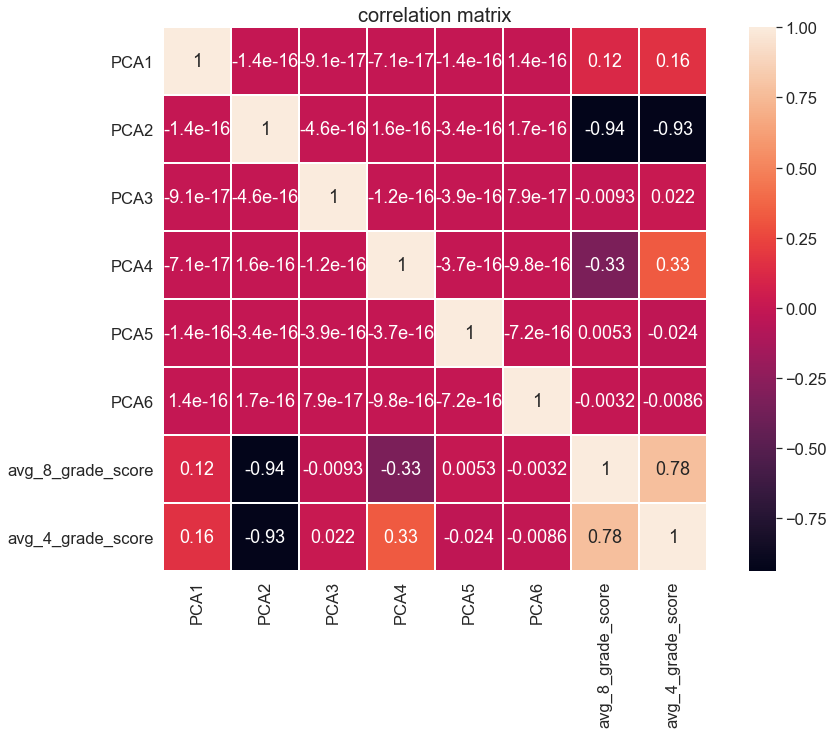

In [149]:
PCA_df1['avg_8_grade_score'] = df0['avg_8_grade_score']
PCA_df1['avg_4_grade_score'] = df0['avg_4_grade_score']
# make the correlation matrices.
corrmat_scores = PCA_df1.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(15,10))
# draw the heatmap using seaborn.
sns.heatmap(corrmat_scores, square=True, annot=True, linewidths=.5) #, label='small')
plt.title("correlation matrix", size=20)
plt.show()

## The correlation between the first principal and the average score is around 14%

# 5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

## Yes and no. Yes if calculation performance and curse of dimensionality are important factors to consider. Otherwise, I will use the actual variables.